## EE 372 Assignment 1

#### Name:  
#### Date: 

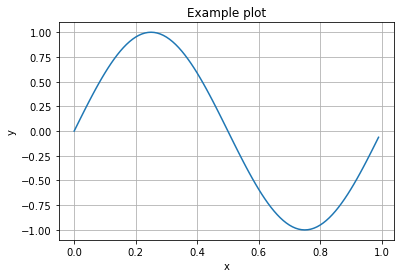

In [1]:
%matplotlib inline

# The only libraries you should need for this assignment. 
# Execute this cell first. (You should get a sine wave.)
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(0,1.0, 0.01)
y = np.sin(2*np.pi*x)
plt.plot(x,y)
plt.grid()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Example plot')
plt.show()

### Question I: Sanger Sequencing

1.

In a Sanger sequencing experiment, a bio-chemist observes that the masses of molecules that are terminated by ddATP are 400, 1200, and 1351. The masses of molecules terminated by ddCTP are 531, and 1482. The masses of the molecules terminated by ddGTP are 671, 813, and 961. The masses of the molecules terminated by ddTTP are 1093, and 1657. The primer used here is AGC. What is the molecule being sequenced?

In [2]:
rseq = 'AGC' + ''.join([x[0] 
                        for x in sorted([('A', 400), ('A', 1200), ('A', 1351), 
                                         ('C', 531), ('C', 1482), 
                                         ('G', 671), ('G', 813), ('G', 961),
                                         ('T', 1093), ('T', 1657)],
                                        key=lambda x:x[1])])

base_pairs = {'A':'T', 'C':'G', 'G':'C', 'T':'A'}
seq = ''.join(map(lambda x:base_pairs[x], rseq))

print('Reverse complement sequence (written in 5\'->3\' direction) is %s.'%(rseq))
print('Molecule being sequenced (written in 5\'->3\' direction) is %s.'%(seq[::-1]))

Reverse complement sequence (written in 5'->3' direction) is AGCACGGGTAACT.
Molecule being sequenced (written in 5'->3' direction) is AGTTACCCGTGCT.


2.


Assume that A, G, C, T have the same molecular weight, and the masses measured have a tolerance of $\pm$ 0.05%. Give a bound on the maximum length that can be sequenced without error (assuming all measurements are within $\pm$ 0.05% of the true value). How does this change when the molecular weights are different?

Assume each nucleotide has mass $m$ and the length of the molecule is $L$. To avoid error measurement, we should have $\max(mL) < \min(m(L+1))$, which means that $Lm(1+\delta) < (L+1)m(1-\delta)$. Therefore with $\delta = 0.0005$, 

$$ L \leq \left\lfloor \frac{(1-\delta)}{2\delta} \right\rfloor = 999.5 $$

When the nucleotides have different weights, we need to only consider the max mass nucleotide with mass $m_M$ and the min mass nucleotide with mass $m_m$. Instead of $Lm$ from before, we now have 

$$ \sum_{i=1}^{L} m_i(1-\delta). $$

Therefore $\max(mL) < \min(m(L+1))$ now becomes

$$ Lm_M(1+\delta) < (L+1)m_m(1-\delta) $$

which can be simplified to

$$ L \leq \left\lfloor \frac{m_m(1-\delta)}{m_M(1+\delta) - m_m(1-\delta)} \right\rfloor. $$

### Question II: Base calling for Illumina sequencing

1.

Express $Q_{ij}$ in terms of $i$, $j$, and $p$. Given $j$ and $p$, at which value of $i$ is $Q_{ij}$ maximized? Bonus: Can you connect the $i$-th row of $Q$ to the pmf of some well known distribution?

We can express $Q_{ij}$ as

$$ Q_{ij} = {i-1 \choose i-j} p^{i-j} (1-p)^j $$

which is a negative binomial distribution in $i$ for fixed $j$. The mode (i.e. value of $i$ at which $Q_{ij}$ is maximized) of a negative binomial distribution is 

$$ \left\lfloor \frac{p(j-1)}{1-p} \right\rfloor $$

if $j > 1$. Otherwise the mode is 0. 

2.

Simulate and plot $y(1),\dots,y(L)$ according to the probability model (for $s(j)$ being i.i.d. equally probable to be 0 or 1). Do this for various values of $p=0,0.01,0.05,0.1,0.2 $ and for $\sigma^2 = 0.1$

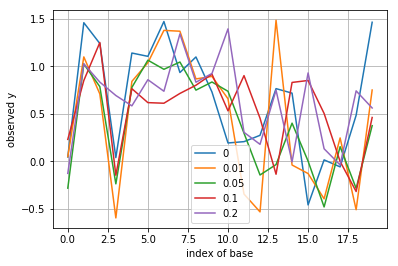

In [3]:
from scipy.special import comb
np.random.seed(0)

L = 20
list_p = [0, 0.01, 0.05, 0.1, 0.2]
sigma = np.sqrt(0.1)

s = np.random.choice([0, 1], L)
Qs = [] # save all Q's

for p in list_p:
    Q = np.zeros((L, L))
    for j in range(1, 1+L):
        for i in range(j, 1+L):
            Q[i-1, j-1] = comb(i-1, i-j)*p**(i-j)*(1-p)**j
    Qs.append(Q)
    
    y = np.dot(Q, s) + np.random.normal(0, sigma, L)
    plt.plot(y, label=p)
        
plt.legend()
plt.xlabel('index of base')
plt.ylabel('observed y')
plt.grid()
plt.show()

3.

After writing down your zero-forcing equalizer and the decoding rule, simulate this rule and for different values of $p$ plot its quality score $Q$ as a function of position along the DNA sequence. 

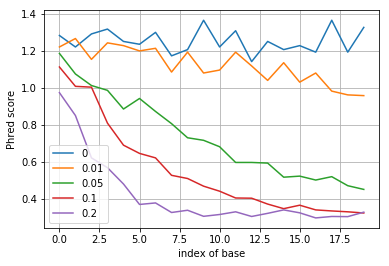

In [4]:
np.random.seed(0)
num_sim = 1000

for i, p in enumerate(list_p):
    s_hat = np.zeros((num_sim, L))
    s = np.random.choice([0, 1], (num_sim, L))
    for j in range(num_sim):
        y = np.dot(Qs[i], s[j]) + np.random.normal(0, sigma, L)
        s_hat[j] = (np.dot(np.linalg.pinv(Qs[i]), y) > 0.5).astype(int)

    p_error = np.sum(s_hat != s, 0)/float(num_sim)
    plt.plot(-np.log10(p_error), label=p)

        
plt.legend()
plt.xlabel('index of base')
plt.ylabel('Phred score')
plt.grid()
plt.show()

4.

After writing down the formula for the MMSE equalizer
and the corresponding decoding rule, simulate this rule and for different values of $p$ plot the resulting quality score as a function of position along the DNA sequence.

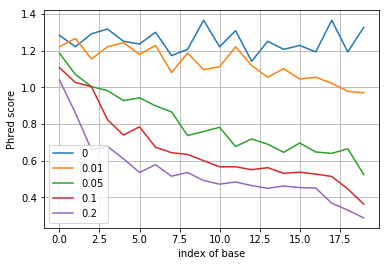

In [5]:
np.random.seed(0)
num_sim = 1000

for i, p in enumerate(list_p):
    s_hat = np.zeros((num_sim, L))
    s = np.random.choice([0, 1], (num_sim, L))
    for j in range(num_sim):
        y = np.dot(Qs[i], s[j]) + np.random.normal(0, sigma, L)
        Q = np.matrix(Qs[i])
        s_hat[j] = (Q.T*(0.25*Q*Q.T+sigma**2*np.eye(L))**-1 \
                       *(y.reshape(-1, 1)-0.5*Q*np.ones((L, 1))) \
                    +0.5*np.ones((L, 1)) > 0.5).astype(int).reshape(-1)

    p_error = np.sum(s_hat != s, 0)/float(num_sim)
    plt.plot(-np.log10(p_error), label=p)

        
plt.legend()
plt.xlabel('index of base')
plt.ylabel('Phred score')
plt.grid()
plt.show()

5.i.

After finding the appropriate detection rule, plot the quality score for a fixed $p=0.05$ as a function of the position $m$. Compare this to the performance of the base calling rules in parts 3. and 4.

The detection rule here is

$$ \mathbb{I} \left\{Q_{i,.}\mathbf{s} \ > \frac{1}{2} Q_{i,.} Q_{i,.}^T \right\} $$

where $Q_{i,.}$ refers to the $i$th row of $Q$.

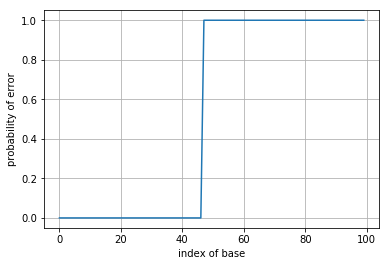

In [6]:
np.random.seed(0)
num_sim = 100
L = 100
p = 0.05

Q = np.zeros((L, L))
for j in range(1, 1+L):
    for i in range(j, 1+L):
        Q[i-1, j-1] = comb(i-1, i-j)*p**(i-j)*(1-p)**j

p_error = []
Q = np.matrix(Q)
for i, l in enumerate(range(L)):
    s = np.zeros((L,1))
    s[l] = 1
    s_hat = []
    for j in range(num_sim):
        y = np.dot(Q, s) + np.random.normal(0, sigma, L)
        yi = Q[i,:].dot(s)
        s_hat.append(yi > 0.5*Q[i,:].dot(Q[i,:].T))
    p_error.append(1-np.sum(s_hat)/float(L))
    
plt.plot(p_error)
plt.xlabel('index of base')
plt.ylabel('probability of error')
plt.grid()
plt.show()

5 ii

What happens to this probability of error as a function of position in this case? What does this say about why the read length in Illumina sequencing is limited?

6.

Consider now the general case when $q \neq 0$. After writing $Q_{ij}$ in terms of $\{Q_{\ell, k}\}_{\ell \leq i-1, k \leq j}$, write a short piece of code that outputs a 10 x 10 matrix Q with $p = 0.1, q = 0.2$. _Hint_: Dynamic programming.

[[8.00e-01 2.00e-01 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 5.60e-01 3.00e-01 4.00e-02 0.00e+00 0.00e+00 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 5.60e-02 4.22e-01 3.26e-01 8.80e-02 8.00e-03 0.00e+00 0.00e+00
  0.00e+00 0.00e+00]
 [0.00e+00 5.60e-03 8.14e-02 3.39e-01 3.21e-01 1.28e-01 2.32e-02 1.60e-03
  0.00e+00 0.00e+00]
 [0.00e+00 5.60e-04 1.21e-02 9.20e-02 2.86e-01 3.06e-01 1.56e-01 4.19e-02
  5.76e-03 3.20e-04]
 [1.38e-03 5.60e-05 1.60e-03 1.78e-02 9.54e-02 2.49e-01 2.87e-01 1.74e-01
  6.11e-02 1.24e-02]
 [2.11e-02 5.60e-06 1.99e-04 2.91e-03 2.23e-02 9.52e-02 2.22e-01 2.68e-01
  1.86e-01 7.89e-02]
 [9.45e-02 5.60e-07 2.38e-05 4.31e-04 4.30e-03 2.57e-02 9.33e-02 2.01e-01
  2.51e-01 1.91e-01]
 [1.94e-01 5.60e-08 2.77e-06 5.99e-05 7.37e-04 5.67e-03 2.82e-02 9.06e-02
  1.85e-01 2.35e-01]
 [2.21e-01 5.60e-09 3.17e-07 7.94e-06 1.16e-04 1.09e-03 6.93e-03 2.99e-02
  8.75e-02 1.71e-01]]


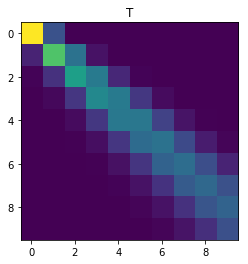

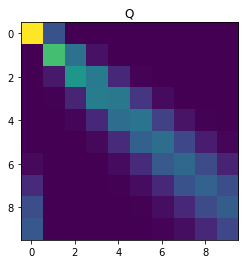

In [7]:
import itertools
np.set_printoptions(precision=2)

L = 10
T = np.zeros((L,L))
Q = np.zeros((L,L))
p = 0.1
q = 0.2

T[0, 0] = 1 - q
T[0, 1] = q
Q[0, 0] = 1 - q
Q[0, 1] = q
for i,j in itertools.product(range(1,10), range(10)):
    if j == 0:
        T[i][j] = p*T[i-1][j]
    elif j == 1:
        T[i][j] = p*T[i-1][j] + (1-p-q)*T[i-1][j-1]
    else:
        T[i][j] = p*T[i-1][j] + (1-p-q)*T[i-1][j-1] + q*T[i-1][j-2]
        
for i,j in itertools.product(range(1,10), range(10)):

    if j == 1:
        Q[i][j] = (1-p-q)*T[i-1][j-1]
    else:
        Q[i][j] = (1-p-q)*T[i-1][j-1] + q*T[i-1][j-2]
        
print(Q)
plt.imshow(T, interpolation='None')
plt.title('T')
plt.show()
plt.imshow(Q, interpolation='None')
plt.title('Q')
plt.show()

### Question III: Playing around with reads

1.

We are given $N$ reads of length $L$ and a reference genome of length $\ell$. Assuming reads were sampled uniformly from the entire genome, what is the expected number of times a base at a particular position will be sequenced? In other words, what is the sequencing depth of each base in the genome? What is the probability that we see the exact same read twice? You can assume that if a length-$L$ sequence appears in the genome, it appears exactly once.

There are a total of $\ell-L+1$ unique read positions in the genome. Since each read is length $L$, the probability of a read containing our base is $L/(\ell-L+1)$. Since each read is drawn independently, we expect each base to be sequenced

$$ \frac{NL}{\ell-L+1} $$

times (ignoring edge cases for bases at the ends of the genome). The probability of seeing a single read twice is 

$$ {N \choose 2} \left( \frac{1}{\ell-L+1} \right)^2 \left( 1- \frac{1}{\ell-L+1} \right)^{N-2}. $$

Intuitively, the probability of getting 2 of the same draws from $N$ draws can be modeled using a binomial distribution where the probability of success is the probability of sampling a particular sequence.

2.

Download the reference genome for E. coli here, and download a set of reads obtained from an E. coli experiment here (you can right click each link and select “Save Link As”, and you will need to unzip the fastq file containing the reads).
- What is the length of the reference?
- What is the length of each read?
- How many reads are there?
- What is the maximum number of times a read is repeated?
- What is the sequencing depth of each base in the reference for this experiment? _Hint:_ Use the formula you got from above.

The length of the reference is 4639735 bp. The length of each read is 150 bp. There are 644022 reads total. The maximum number of times a read is repeated is 11 times. This is the read consisting of only N nucleotides. If we exclude this read, then the maximum number of times a read is repeated is 1 time. Using the formula from above, the sequencing depth for each base is 

$$ \frac{644022*150}{4639735-150+1} \approx 20.82.$$

3.

How many distinct 20-length substrings do you see across all reads? These substrings are commonly referred to as $k$-mers where $k$ = 20. Count how often each distinct 20-mer appears and generate a histogram of the counts. _Hint_: Note that initializing a length-$4^{20}$ array may not be a viable approach. Consider using dictionaries!

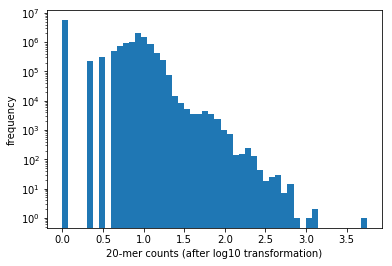

There are 14698917 distinct 20-mers.


In [9]:
d = {}

with open('e.coli_k12_atcc_700926.fastq') as f:
    for line_num, seq in enumerate(f):
        if line_num%4 == 1:
            for i in range(0, len(seq)-20):
                kmer = seq[i:i+20]
                if kmer not in d:
                    d[kmer] = 1
                else:
                    d[kmer] += 1

counts = np.array(d.values())
plt.hist(np.log10(counts), bins=50)
plt.xlabel('20-mer counts (after log10 transformation)')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

print('There are %s distinct 20-mers.'%(len(d)))

4.

Bowtie2 is a popular read aligner optimized for aligning large amounts of short reads to long references. Bowtie2 is preinstalled on Stanford’s Rice cluster, but you can also install Bowtie2 on your local machine by downloading the binary.
- Build a Bowtie2 index from the E. coli reference genome (`bowtie2-build` command). You can copy the downloaded files from your computer to Rice using the scp command. Briefly describe the algorithms involved with building the index.
- Using the default settings, use Bowtie2 to align the E. coli reads to the newly built Bowtie2 index. Use Bowtie2’s `-t` option to obtain the runtime. How many reads have at least 1 reported alignment? What was the runtime?

The algorithms involved with building the index are: 

1. Karkkainen’s blockwise algorithm (a new space-and time-efficient algorithm for computing the Burrow–Wheeler transform)
2. FM indexing (result of taking the Burrows-Wheeler transform (BWT) of the input text)
3. Burrows-Wheeler transform (rearranges a character string into runs of similar characters, which is useful for compression)

We built the index using 

```
bowtie2-build E.coli_K12_ATCC_700926.fasta ecoli
``` 

and we aligned the reads using 

```
bowtie2 -x ecoli -U e.coli_k12_atcc_700926.fastq -t -S ecoli_aligned_reads.sam
``` 

We obtained the following output:

```
Time loading reference: 00:00:00
Time loading forward index: 00:00:00
Time loading mirror index: 00:00:00
Multiseed full-index search: 00:01:14
644022 reads; of these:
  644022 (100.00%) were unpaired; of these:
    16160 (2.51%) aligned 0 times
    609573 (94.65%) aligned exactly 1 time
    18289 (2.84%) aligned >1 times
97.49% overall alignment rate
Time searching: 00:01:32
Overall time: 00:01:32
```

627862 reads have at least 1 reported alignment, and the runtime was 92 seconds.